# Assignment 2 - MATH60837A
William Bourque - 11359215

Frederic Pelletier - 11359258

## installing dependencies (only needed once)

In [63]:
%pip install numpy
%pip install matplotlib
%pip install seaborn
%pip install pandas
%pip install statsmodels
%pip install arch

44264.04s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


44270.00s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


44276.05s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


44281.74s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


44287.41s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


44293.08s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## importing dependencies

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.tsa.stattools import acf, pacf, q_stat
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import chi2
from arch import arch_model
import warnings
warnings.filterwarnings("ignore")

## Loading the data

In [65]:
df = pd.read_csv('./data.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)
df['log_HP'] = np.log(df['QCAR628BIS'])
df['diff_HP'] = df['log_HP'].diff()
df = df.dropna()
yt = df['diff_HP']
zt = df['log_HP']
df.head()

,QCAR628BIS,log_HP,diff_HP
DATE,,,
1970-04-01,37.6448,3.628195,-0.004937
1970-07-01,37.6462,3.628232,0.000037
1970-10-01,38.9141,3.661357,0.033125
1971-01-01,39.0319,3.664379,0.003023
1971-04-01,38.9859,3.663200,-0.001179


# Part1.Model Selection

### 1.a) Estimate all 4 models by maximum likelihood, report the estimation results, and verify if the stationarity conditions and invertibility conditions are satisfied

In [66]:
def test_stationarity(model: ARIMA):
    p,_,q = model.specification.order
    r = max(p,q)
    phi_matrix = np.zeros((r,r))
    phis = model.arparams
    phi_matrix[0,:] = np.pad(model.arparams, (0, r - len(phis)), mode='constant')
    np.fill_diagonal(phi_matrix[1:p,:p],1)
    eigenvalues = np.linalg.eigvals(phi_matrix)
    print(phi_matrix)
    return np.all(np.abs(eigenvalues) < 1)

def test_invertibility(model:ARIMA):
    p,_,q = model.specification.order
    r = max(p,q)
    theta_matrix = np.zeros((r,r))
    thetas = model.maparams
    theta_matrix[0,:] = np.pad(thetas, (0,r - len(thetas)), mode='constant')
    np.fill_diagonal(theta_matrix[1:q,:q],1)
    eigenvalues = np.linalg.eigvals(theta_matrix)
    print(theta_matrix)
    return np.all(np.abs(eigenvalues) < 1)

In [67]:
#since we will be testing for stationarity and invertibility, we do not force the
# algorithm to ensure either of them
ar4 = ARIMA(yt, order=(4,0,0), enforce_stationarity=False, enforce_invertibility=False).fit()
arma41 = ARIMA(yt, order=(4,0,1),enforce_stationarity=False, enforce_invertibility=False).fit()
arma42 = ARIMA(yt, order=(4,0,2),enforce_stationarity=False, enforce_invertibility=False).fit()


for name,model in {'ar(4)': ar4,'arma(4,1)': arma41,'arma(4,2)': arma42}.items():
    stationary = test_stationarity(model)
    invertible = test_invertibility(model)
    print(model.summary())
    print(f'{name} is {"stationary" if stationary else "not stationary"}')
    print(f'{name} is {"invertible" if invertible else "not invertible"}')
    

[[ 0.2962334  -0.17990266  0.12186389  0.18784564]
 [ 1.          0.          0.          0.        ]
 [ 0.          1.          0.          0.        ]
 [ 0.          0.          1.          0.        ]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
                               SARIMAX Results                                
Dep. Variable:                diff_HP   No. Observations:                  216
Model:                 ARIMA(4, 0, 0)   Log Likelihood                 465.138
Date:                Wed, 19 Feb 2025   AIC                           -918.276
Time:                        20:38:07   BIC                           -898.137
Sample:                    04-01-1970   HQIC                          -910.137
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

### Interpretation
All models are both stationary and invertible since the eigenvalues of their respective phi and theta matrices all have modules less than 1. However, for all models, some parameters 
do not have a p-value < 0.05, meaning there is no strong statistical evidence that the parameter should be different than 0

### 1.b) Select a model among the 3 using the BIC criterion. Perform likelihood ratio tests (using a 5% significance level) to discriminate between that model and possible alternatives among the remaining 2. Evaluate the white noise hypothesis for the residuals to justify the selection of a final model.

In [68]:
# We evaluate the BIC creterion for each model
print(f'BIC for AR(4): {ar4.bic}')
print(f'BIC for ARMA(4,1): {arma41.bic}')
print(f'BIC for ARMA(4,2): {arma42.bic}')


BIC for AR(4): -898.1369393585808
BIC for ARMA(4,1): -898.9625272867863
BIC for ARMA(4,2): -893.6309898088599


In [69]:
# We first define a function to help us perform the test
def likelihood_ratio_test(l1,l0,k, alpha):
    statistic = 2*(l1 - l0)
    critical_value = chi2.ppf(1 - alpha, k)
    print(f'{statistic=}, {critical_value=}')
    print('p-value:',1 - chi2.cdf(statistic, k)) # P(chi2 > statistic)
    return statistic > critical_value

In [70]:
model_from_first_test = None
model_from_second_test = None
can_reject_null = likelihood_ratio_test(arma41.llf, ar4.llf, 1, 0.05)
if can_reject_null:
    print('we can reject the null hypothesis, meaning we pick the AMRA(4,1)')
    model_from_first_test = arma41
else:
    print('we cannot reject the null hypothesis, meaning we pick the AR(1)')
    model_from_first_test = ar4

can_reject_null = likelihood_ratio_test(arma42.llf, model_from_first_test.llf, 1, 0.05)
if can_reject_null:
    print('we can reject the null hypothesis, meaning we pick the ARMA(4,2)')
    model_from_second_test = arma42
else:
    print('we cannot reject the null hypothesis, meaning we pick the ARMA(4,1)')
    model_from_second_test = arma41

selected_model = model_from_second_test

statistic=6.182174202877491, critical_value=3.8414588206941205
p-value: 0.012904361528022879
we can reject the null hypothesis, meaning we pick the AMRA(4,1)
statistic=0.025048796745636537, critical_value=3.8414588206941205
p-value: 0.8742455306934236
we cannot reject the null hypothesis, meaning we pick the ARMA(4,1)


In [71]:
# We perform the Lyung-Box test to make sure the residuals of the model are white noise
residuals = selected_model.resid
lags = range(1, 19)  # Creat a vector for lags 1 to 18

# Perform the Ljung-Box Q-test
lbq_result = acorr_ljungbox(residuals, lags=lags, return_df=True)

p_values = lbq_result['lb_pvalue']
test_statistics = lbq_result['lb_stat']
h1 = (p_values < 0.05).astype(int)  # Binary decision rule (1 = reject null hypothesis)

# Print the results
print("Decision Rule (h1):", h1.values)
print("P-Values:", p_values.values)
print("Test Statistics:", test_statistics.values)
acf(residuals,nlags=20)

if h1.mean() == 0:
    chosen_model = selected_model

Decision Rule (h1): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
P-Values: [0.9886114  0.999097   0.98036342 0.99233632 0.98487548 0.99170751
 0.93508861 0.74353155 0.7475653  0.29347145 0.28100001 0.3452968
 0.42033275 0.33642305 0.39789475 0.4394618  0.49018685 0.5128529 ]
Test Statistics: [2.03746626e-04 1.80681875e-03 1.82501760e-01 2.58445637e-01
 6.64201248e-01 8.13474024e-01 2.39086266e+00 5.13059124e+00
 5.92334283e+00 1.18755559e+01 1.31913991e+01 1.33331683e+01
 1.33609572e+01 1.56310151e+01 1.57641871e+01 1.61946262e+01
 1.64787256e+01 1.71494568e+01]


### Interpretation 
Using the BIC creterion the selected model is the ARMA(4,1), because its value of -898.96 was the smallest among the three models. To verify the potency of this result we perform the likelihood ratio test. The first test uses the AR(4) as null hypothesis angainst the ARMA(4,1). The p-value is smaller than the chosen alpha meaning we reject the null and select the ARMA(4,1). The second test uses the selected model from the first test, ARMA(4,1) as the null against the ARMA(4,2). The p-value is greater than the chosen alpha meaning we cannot reject the null and select once again the ARMA(4,1). To verify the white noise hypothesis for the residuals we perform the Lyung-Box test. The test is concluent, we cannot reject the null for the first 18 lags, it suggests that the residuals are white noise and the model can bu useful.

# Part 2. Dynamic Response and forecasting

### 2.a) For the selected model, evaluate the dynamic response for an horizon of 10 periods following a positive shock of size sigma = 1.15 occuring at the first period of the horizon, and explain what happens.

const     0.006584
ar.L1    -0.336585
ar.L2     0.027431
ar.L3    -0.016865
ar.L4     0.303607
ma.L1     0.679083
sigma2    0.000704
dtype: float64


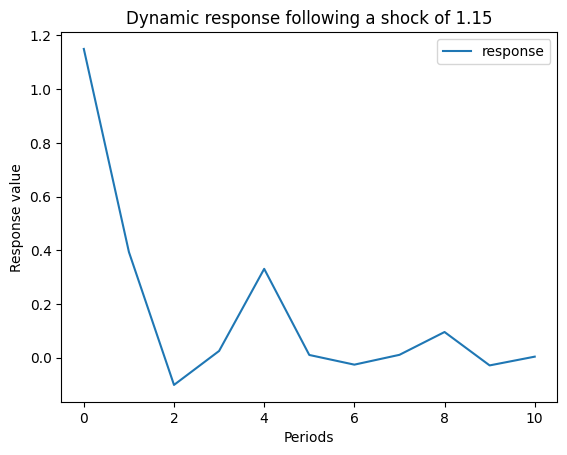

In [72]:
print(chosen_model.params)
plt.plot(chosen_model.impulse_responses(10,[1.15]), label='response')
plt.xlabel('Periods')
plt.ylabel('Response value')
plt.title('Dynamic response following a shock of 1.15')
plt.legend()

### Interpretation 

We can see that following the shock, the dynamic response quickly fades to 0. However, it is not strictly decreasing, which makes sense given the polynomial nature of the dynamic response equation.

### 2.b) For the selected model, evaluate the dynamic response for an horizon of 10 periods following a positive shock of size occurs during 3 consecutive periods of the horizon (t, t+1, t+2). Plot the impulse response function, showing the dynamic response for an horizon of 20 periods following these shocks, and explain what happens.

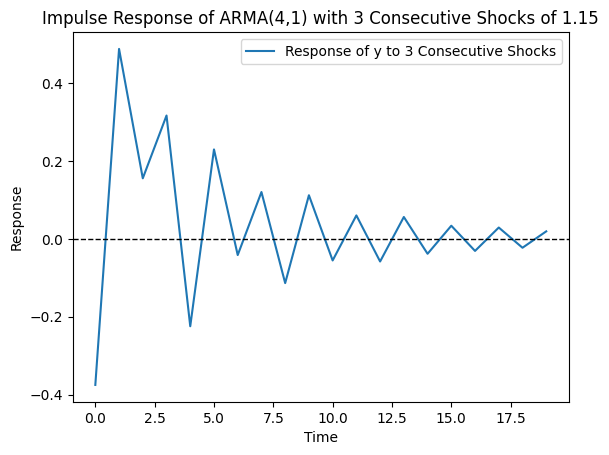

In [73]:
#we have to use the definition with psi_0 = psi_1 = psi_2 = 1.15
n_periods = 20
shocks = [1.15,1.15,1.15]
total_n_periods = n_periods + len(shocks)
responses = np.append(shocks,[0] * n_periods)
p = len(chosen_model.arparams)
q = len(chosen_model.maparams)
for i in range(len(shocks), total_n_periods):
    p_indices = [i - j for j in range(1,p+1)]
    q_indices = [i - j for j in range(1,q+1)]
    prev_shocks = [responses[pi] if pi >= 0 else 0 for pi in p_indices]
    prev_noises = [1 if qi == 0 else 0 for qi in q_indices]
    responses[i] = np.dot(prev_shocks,chosen_model.arparams) - np.dot(prev_noises, chosen_model.maparams) + (1 if i == 0 else 0)
plt.plot(responses[3:],  label="Response of y to 3 Consecutive Shocks")

# Plot impulse responses
plt.axhline(y=0, linestyle="--", color="black", linewidth=1)
plt.xlabel("Time")
plt.ylabel("Response")
plt.title("Impulse Response of ARMA(4,1) with 3 Consecutive Shocks of 1.15")
plt.legend()
plt.show()

### Interpretation

We can see the the dynamic response takes a longer time before reaching 0, oscillating up and down the 0 line. This is due to the fact that the high-valued shocks, i.e. those with value 1.15, get picked up longer in the recursion, increasing the value of several of the next iterations.

### 2.c) Forecasting: Split the sample into a training sample and a holdout sample. The holdout sample should consist of the last 34 observations 

 - Re-estimate the selected model using only the training sample
 - Calculate the 1-step ahead forecasts for the stationarized series
 - Plot these forecasts along with the actual series on the same graph for the period covered by the hold-out sample
 - Now calculate and plot the level (as opposed to first difference) of the variable zt against its 1-step ahead forecasts from the 2 models and from the naive forecast E(zt+1) = zt

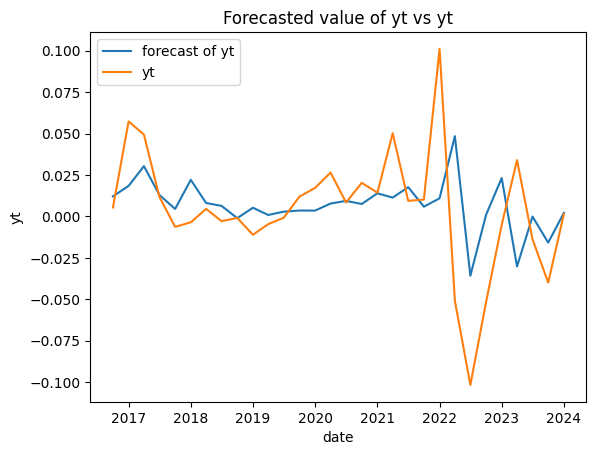

In [74]:
training_set = yt[:-34]
test_set = yt[-34:] #last 34 data points
forecast_model_init = ARIMA(training_set, order=(4,0,1),enforce_stationarity=False, enforce_invertibility=False).fit()

initial_chunk = test_set.iloc[:4]
forecast_model = forecast_model_init.extend(initial_chunk)


y_forecast_values = []
forecast_dates = test_set.index[4:]  # Get the dates for forecasts

for i in range(4, len(test_set)):
    next_value = test_set.iloc[i]  

    # Generate 1-step-ahead forecast
    forecast_value = forecast_model.forecast(steps=1)[0]
    y_forecast_values.append(forecast_value)

    # Extend the model with the new observed value
    forecast_model = forecast_model.extend([next_value])

# Convert forecasts into a Pandas DataFrame
forecast_df = pd.DataFrame({"Forecast": y_forecast_values}, index=forecast_dates)

# Print results
plt.plot(forecast_df, label='forecast of yt')
plt.plot(test_set[4:], label='yt')
plt.legend()
plt.title('Forecasted value of yt vs yt')
plt.ylabel('yt')
plt.xlabel('date')
plt.show()

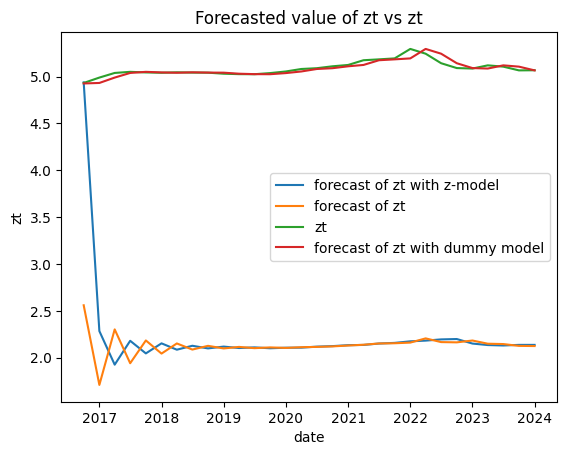

In [75]:
z_training_set = zt[:-34]
z_test_set = zt[-34:]

forecast_model_init = ARIMA(training_set, order=(4,0,1),enforce_stationarity=False, enforce_invertibility=False).fit()
z_forecast_model_init = ARIMA(z_training_set, order=(4,0,1),enforce_stationarity=False, enforce_invertibility=False).fit()

initial_chunk = np.asarray(z_test_set.iloc[:4])
forecast_model = forecast_model_init.extend(initial_chunk)
z_forecast_model = z_forecast_model_init.extend(initial_chunk)

forecast_values = []
z_forecast_values = []

forecast_dates = z_test_set.index[4:]  # Get the dates for forecasts

for i in range(4, len(z_test_set)):
    next_value = z_test_set.iloc[i]  

    # Generate 1-step-ahead forecast
    forecast_value = forecast_model.forecast(steps=1)[0]
    forecast_values.append(forecast_value)

    z_forecast_value = z_forecast_model.forecast(steps=1)[0]
    z_forecast_values.append(z_forecast_value)


    # Extend the model with the new observed value
    forecast_model = forecast_model.extend([next_value])
    z_forecast_model = forecast_model.extend([next_value])
# Convert forecasts into a Pandas DataFrame
forecast_df = pd.DataFrame({"Forecast": forecast_values}, index=forecast_dates)
z_forecast_df = pd.DataFrame({"Forecast": z_forecast_values}, index=forecast_dates)


plt.plot(z_forecast_df, label='forecast of zt with z-model')
plt.plot(forecast_df, label='forecast of zt')
plt.plot(z_test_set[4:], label='zt')
plt.plot(z_test_set.shift(1).dropna()[3:], label='forecast of zt with dummy model')
plt.plot()
plt.legend()
plt.title('Forecasted value of zt vs zt')
plt.ylabel('zt')
plt.xlabel('date')
plt.show()

### 2.d) Report the Mean-Squared Error for the selected model using only the hold-out sample of 34 observations to evaluate the forecast performance. Compare these statistics to those from the naive forecast. What model should we use?

In [76]:
mse_model = sum((test_set[4:] - y_forecast_values) ** 2)
mse_naive = sum((test_set[4:] - test_set.shift(1).dropna()[3:]) ** 2)
print(mse_model, mse_naive)

0.03630196911011798 0.05387968664296247


# Part 3. Further improvements by modelling the conditionnal variance

### 3.a) Plot the autocorrelation and partial autocorrelation functions of y_t squared. What can you conclude? 

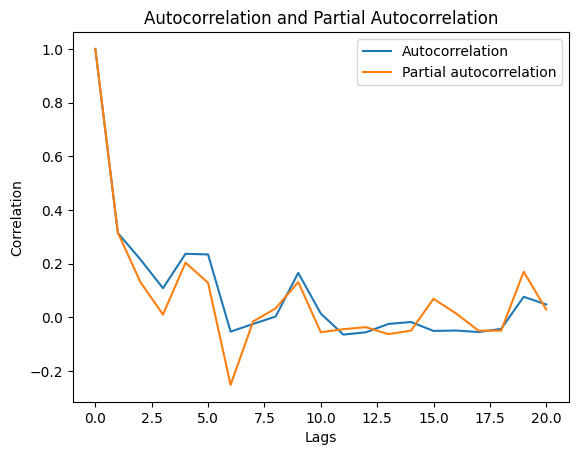

In [77]:
yt_squared = pow(yt,2)
acf_vector = acf(yt_squared, nlags = 20)
pacf_vector = pacf(yt_squared, nlags = 20)

plt.plot(acf_vector, label = 'Autocorrelation')
plt.plot(pacf_vector, label = 'Partial autocorrelation')
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.title('Autocorrelation and Partial Autocorrelation')
plt.legend()
plt.show()


### Interpretation

### 3.b) Estimate the ARCH(1) and GARCH(1,1) versions of the model selected in part 1 using only the training sample, and report the estimates.

In [78]:
residuals = forecast_model_init.resid

arch_model_fit = arch_model(residuals, vol = 'ARCH', p=1).fit()
garch_model_fit = arch_model(residuals, vol = 'GARCH', p=1, q=1).fit()


Iteration:      1,   Func. Count:      5,   Neg. LLF: 5201735.180000575
Iteration:      2,   Func. Count:     15,   Neg. LLF: -279.3184233509386
Iteration:      3,   Func. Count:     22,   Neg. LLF: -418.36087988540623
Iteration:      4,   Func. Count:     27,   Neg. LLF: -424.2773266900865
Iteration:      5,   Func. Count:     32,   Neg. LLF: -423.7121540006949
Iteration:      6,   Func. Count:     37,   Neg. LLF: -424.3462974984926
Iteration:      7,   Func. Count:     40,   Neg. LLF: -424.3462974985034
Optimization terminated successfully    (Exit mode 0)
            Current function value: -424.3462974984926
            Iterations: 7
            Function evaluations: 40
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2078395.442024321
Iteration:      2,   Func. Count:     17,   Neg. LLF: 6193.315450689489
Iteration:      3,   Func. Count:     28,   Neg. LLF: 920.7802000629687
Iteration:      4,   Func. Count:     38,   Neg. LLF: 302.0870091

### Interpretation

### 3.c) Perform likelihood ratio tests to select one model among the original ARMA model selected in part 1, its ARCH(1) alternative, and its GARCH(1,1) alternative.

In [79]:
model_from_llr = None
can_reject_null = likelihood_ratio_test(garch_model_fit.loglikelihood, arch_model_fit.loglikelihood, 1, 0.05)
if can_reject_null:
    print('we can reject the null hypothesis, meaning we select the GARCH(1,1)')
    model_from_llr = garch_model_fit
else:
    print('we cannot reject the null hypothesis, meaning we pick the ARCH(1)')
    model_from_llr = arch_model_fit

statistic=17.102785188087523, critical_value=3.8414588206941205
p-value: 3.541033779130842e-05
we can reject the null hypothesis, meaning we select the GARCH(1,1)


### Interpretation

### 3.d) Perform a specification test on the residuals of the ARCH(1) and GARCH(1,1) components. What is the best model for the conditional variance?

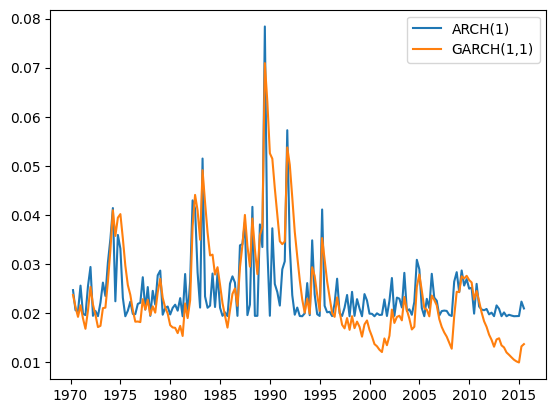

Decision Rule (h1_ARCH(1)): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
P-Values: [0.9886114  0.999097   0.98036342 0.99233632 0.98487548 0.99170751
 0.93508861 0.74353155 0.7475653  0.29347145 0.28100001 0.3452968
 0.42033275 0.33642305 0.39789475 0.4394618  0.49018685 0.5128529 ]
Test Statistics: [ 7.21341222  9.05594262 11.90799706 12.92861443 14.84836375 14.84846952
 14.98184716 18.10404871 35.56275282 38.41362436 38.41597786 38.64024248
 38.76655215 39.36244739 39.64534658 39.72362773 39.97649995 40.02144327]
Decision Rule (h1_GARCH(1,1)): [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
P-Values: [9.28166886e-03 1.40490922e-02 9.57834188e-03 1.45044244e-02
 1.41125302e-02 2.69852695e-02 4.43657092e-02 2.53013720e-02
 6.56538995e-05 4.90646808e-05 1.00265618e-04 1.77170240e-04
 3.12991027e-04 4.49030132e-04 7.04844893e-04 1.15723765e-03
 1.72889346e-03 2.71992619e-03]
Test Statistics: [ 6.76780949  8.530395   11.43805317 12.41714497 14.24730222 14.24800069
 14.40908836 17.50028354 34.76094039 37.3

In [85]:
conditionnal_volatiliy_garch = garch_model_fit.conditional_volatility
conditionnal_volatiliy_arch = arch_model_fit.conditional_volatility

plt.plot(conditionnal_volatiliy_arch, label = 'ARCH(1)')
plt.plot(conditionnal_volatiliy_garch, label = 'GARCH(1,1)')
plt.legend()
plt.show()

# Perform Lyung-Box test for ARCH(1) model
arch_sq_resid = arch_model_fit.resid**2

lags = range(1, 19)  # Creat a vector for lags 1 to 18

lb_arch = acorr_ljungbox(arch_sq_resid, lags=lags, return_df=True)

p_values_arch = lb_arch['lb_pvalue']
test_statistics_arch = lb_arch['lb_stat']
h1_arch = (p_values_arch < 0.05).astype(int) 

print("Decision Rule (h1_ARCH(1)):", h1.values)
print("P-Values:", p_values.values)
print("Test Statistics:", test_statistics_arch.values)

# Perform Lyung-Box test for GARCH(1,1) model
garch_sq_resid = garch_model_fit.resid**2

# Perform the Ljung-Box Q-test
lb_garch = acorr_ljungbox(garch_sq_resid, lags=lags, return_df=True)

p_values_garch = lb_garch['lb_pvalue']
test_statistic_garch = lb_garch['lb_stat']
h1_garch = (p_values_garch < 0.05).astype(int)  # Binary decision rule (1 = reject null hypothesis)

# Print the results
print("Decision Rule (h1_GARCH(1,1)):", h1_garch.values)
print("P-Values:", p_values_garch.values)
print("Test Statistics:", test_statistic_garch.values)





### Interpretation